In [1]:
import joblib
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import XGBRegressor

In [2]:
# load train dataset
usecols=['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
dtype = {
    'id': str,
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

df_sales = pd.read_csv(
    '../data/train.csv',
    usecols=usecols,
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_sales['date'] = df_sales.date.dt.to_period('D')
df_sales

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,1,2013-01-01,1,BABY CARE,0.000000,0
2,2,2013-01-01,1,BEAUTY,0.000000,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0
4,4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,15
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,8
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,10


In [3]:
# load stores dataset
dtype = {
    'store_nbr': 'category',
    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'category'
}

df_stores = pd.read_csv(
    '../data/stores.csv',
    dtype=dtype,
)
df_stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [4]:
# join train to stores
df_sales = pd.merge(df_sales, df_stores, how='left', on='store_nbr')
df_sales

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000000,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000000,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000000,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000000,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,15,Quito,Pichincha,B,6
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,8,Quito,Pichincha,B,6
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148,Quito,Pichincha,B,6
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,10,Quito,Pichincha,B,6


In [5]:
# load holidays dataset
usecols=['date', 'type', 'locale', 'locale_name', 'transferred']
dtype = {
    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'transferred': 'boolean'
}

df_holidays = pd.read_csv(
    '../data/holidays_events.csv',
    usecols=usecols,
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_holidays['date'] = df_holidays.date.dt.to_period('D')
df_holidays = df_holidays.set_index(['date']).sort_index()

df_holidays

,type,locale,locale_name,transferred
date,,,,
2012-03-02,Holiday,Local,Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,False
2012-04-14,Holiday,Local,Libertad,False
2012-04-21,Holiday,Local,Riobamba,False
...,...,...,...,...
2017-12-22,Additional,National,Ecuador,False
2017-12-23,Additional,National,Ecuador,False
2017-12-24,Additional,National,Ecuador,False


In [6]:
df_holidays = df_holidays.reset_index()
df_holidays['is_holiday'] = False
df_holidays.loc[(df_holidays.type == 'Holiday') & (~df_holidays.transferred), 'is_holiday'] = True
df_holidays.loc[(df_holidays.type == 'Transfer'), 'is_holiday'] = True
df_holidays.loc[(df_holidays.type == 'Additional'), 'is_holiday'] = True
df_holidays.loc[(df_holidays.type == 'Bridge'), 'is_holiday'] = True
df_holidays.rename(columns={'type': 'holiday_type'}, inplace=True)
df_holidays = df_holidays[df_holidays.is_holiday == True]
df_holidays = df_holidays.drop_duplicates(subset='date')
df_holidays = df_holidays.set_index(['date']).sort_index()
df_holidays

,holiday_type,locale,locale_name,transferred,is_holiday
date,,,,,
2012-03-02,Holiday,Local,Manta,False,True
2012-04-01,Holiday,Regional,Cotopaxi,False,True
2012-04-12,Holiday,Local,Cuenca,False,True
2012-04-14,Holiday,Local,Libertad,False,True
2012-04-21,Holiday,Local,Riobamba,False,True
...,...,...,...,...,...
2017-12-22,Holiday,Local,Salinas,False,True
2017-12-23,Additional,National,Ecuador,False,True
2017-12-24,Additional,National,Ecuador,False,True


In [7]:
# join to test dataset
df_sales_ = pd.merge(df_sales, df_holidays, how='left', left_on='date', right_index=True)
df_sales_['is_workday'] = True
# get national holidays
df_sales_.loc[(df_sales_.is_holiday) & (df_sales_.locale == 'National'), 'is_workday'] = False
# get local holidays
df_sales_.loc[(df_sales_.is_holiday) & (df_sales_.locale == 'Local') & (df_sales_.city.astype('string') == df_sales_.locale_name.astype('string')), 'is_workday'] = False
# get regional holidays
df_sales_.loc[(df_sales_.is_holiday) & (df_sales_.locale == 'Regional') & (df_sales_.state.astype('string') == df_sales_.locale_name.astype('string')), 'is_workday'] = False

# new year is special
df_sales_['NewYearsDay'] = (df_sales_.date.dt.dayofyear == 1)

# keep neccessary columns
df = df_sales_.drop(['city', 'state', 'holiday_type', 'locale', 'locale_name', 'transferred', 'is_holiday'], axis=1)

df

,id,date,store_nbr,family,sales,onpromotion,type,cluster,is_workday,NewYearsDay
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0,D,13,False,True
1,1,2013-01-01,1,BABY CARE,0.000000,0,D,13,False,True
2,2,2013-01-01,1,BEAUTY,0.000000,0,D,13,False,True
3,3,2013-01-01,1,BEVERAGES,0.000000,0,D,13,False,True
4,4,2013-01-01,1,BOOKS,0.000000,0,D,13,False,True
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,15,B,6,True,False
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,8,B,6,True,False
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148,B,6,True,False
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,10,B,6,True,False


## Try on one store - one family

In [27]:
df_bev_1 = df[(df['store_nbr'] == '1') & (df['family'] == 'BEVERAGES')]
df_bev_1 = df_bev_1[df_bev_1.date.dt.year == 2017]
df_bev_1 = df_bev_1.drop_duplicates()
df_bev_1

,id,date,store_nbr,family,sales,onpromotion,type,cluster,is_workday,NewYearsDay
2596377,2596377,2017-01-01,1,BEVERAGES,0.0,0,D,13,True,True
2598159,2598159,2017-01-02,1,BEVERAGES,1434.0,256,D,13,False,False
2599941,2599941,2017-01-03,1,BEVERAGES,3081.0,364,D,13,True,False
2601723,2601723,2017-01-04,1,BEVERAGES,3039.0,342,D,13,True,False
2603505,2603505,2017-01-05,1,BEVERAGES,2617.0,329,D,13,True,False
...,...,...,...,...,...,...,...,...,...,...
2991981,2991981,2017-08-11,1,BEVERAGES,1006.0,214,D,13,False,False
2993763,2993763,2017-08-12,1,BEVERAGES,1659.0,279,D,13,True,False
2995545,2995545,2017-08-13,1,BEVERAGES,803.0,217,D,13,True,False
2997327,2997327,2017-08-14,1,BEVERAGES,2201.0,321,D,13,True,False


In [28]:
# de-seasonalize 

# average daily sales
y = (
    df_bev_1
    .groupby(['date']).mean()
    .squeeze()
)[['sales']].loc['2017']

ndx = y.index

fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(
    index=ndx,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()
print(X.shape)

(227, 16)


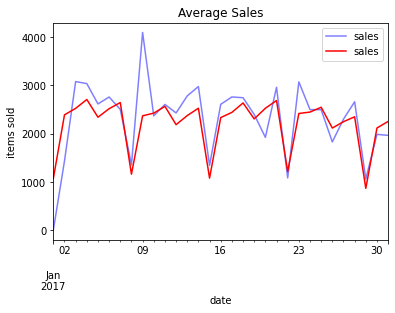

In [29]:
model_1 = LinearRegression().fit(X, y)
y_pred_1 = pd.DataFrame(
    model_1.predict(X),
    index=ndx,
    columns=y.columns,
)

ax = y.loc['2017-01'].plot(color='blue', alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred_1.loc['2017-01'].plot(ax=ax, color='red', label="Seasonal")
ax.legend()

<AxesSubplot:xlabel='date'>

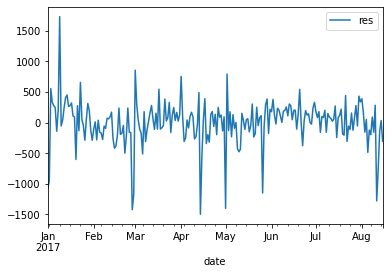

In [30]:
y_res = y - y_pred_1
y_res.columns = ['res']
y_res.plot()
# plt.ylim([-4, 4])

In [31]:
# add deseasonalized daily sales to original dataframe
df_bev_1 = pd.merge(df_bev_1[df_bev_1['date'].dt.year == 2017], y_res.reset_index(), how='left', on='date', suffixes=(None, None))
print(df_bev_1.shape)
df_bev_1

(227, 11)


,id,date,store_nbr,family,sales,onpromotion,type,cluster,is_workday,NewYearsDay,res
0,2596377,2017-01-01,1,BEVERAGES,0.0,0,D,13,True,True,-1070.645255
1,2598159,2017-01-02,1,BEVERAGES,1434.0,256,D,13,False,False,-956.697187
2,2599941,2017-01-03,1,BEVERAGES,3081.0,364,D,13,True,False,555.694173
3,2601723,2017-01-04,1,BEVERAGES,3039.0,342,D,13,True,False,329.446403
4,2603505,2017-01-05,1,BEVERAGES,2617.0,329,D,13,True,False,275.448069
...,...,...,...,...,...,...,...,...,...,...,...
222,2991981,2017-08-11,1,BEVERAGES,1006.0,214,D,13,False,False,-1279.313096
223,2993763,2017-08-12,1,BEVERAGES,1659.0,279,D,13,True,False,-767.128017
224,2995545,2017-08-13,1,BEVERAGES,803.0,217,D,13,True,False,-144.879104
225,2997327,2017-08-14,1,BEVERAGES,2201.0,321,D,13,True,False,33.128354


In [32]:
X_2 = df_bev_1.drop(['id', 'date', 'store_nbr', 'family', 'sales', 'res'], axis=1)
X_2['type'] = X_2['type'].cat.codes
X_2['cluster'] = X_2['cluster'].cat.codes

y_2 = df_bev_1[['res']]

model_2 = XGBRegressor(
    n_estimators=100, 
    max_depth=6, 
    colsample_bytree=0.8, 
    reg_alpha=0.5,
    seed=42,
)
model_2.fit(X_2, y_2)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [33]:
y_pred_2 = pd.DataFrame(
    model_2.predict(X_2),
    index=ndx,
    columns=y.columns,
)


# y_pred_2 = model_2.predict(X)

RMSE_fit = sqrt(mean_squared_error(y_2['res'], y_pred_2))
RMSE_fit

193.00102433026507

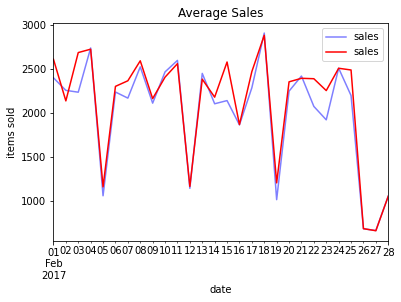

In [34]:
final = y_pred_1 + y_pred_2.rename({'res':'sales'}, axis=1)

ax = y.loc['2017-02'].plot(color='blue', alpha=0.5, title="Average Sales", ylabel="items sold")
ax = final.loc['2017-02'].plot(ax=ax, color='red', label="Seasonal")
ax.legend()

## Create separate models for each families

In [25]:
class BoostedHybrid:

    def __init__(self, model_1, model_2) -> None:
        self.model_1 = model_1
        self.model_2 = model_2
        self.columns = None


    def fit(self, X_1, X_2, y):

        # save columns
        self.columns = y.columns
        
        # fit first model
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.columns
        )

        y_res = y - y_fit

        # fit second model to residuals
        self.model_2.fit(X_2, y_res)


    def predict(self, X_1, X_2):
        # predict with first model
        y_pred_1 = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.columns
        )

        # predict with second model
        y_pred_2 = pd.DataFrame(
            self.model_2.predict(X_2),
            index=X_1.index,
            columns=self.columns
        )

        return y_pred_1 + y_pred_2
        

In [46]:
# utility functions

def get_deterministic_process(index):
    fourier = CalendarFourier(freq='M', order=4)
    dp = DeterministicProcess(
        index=index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True,
    )
    return dp

def prepare_dataframe(df, family, store_nbr):
    """ Filters rows and columns. """
    
    # use only 2017 data for training
    df_ = df[df['date'].dt.year == 2017]
    # filter dataset
    df_ = df_[(df_['family'] == family) & (df_['store_nbr'] == store_nbr)]
    # drop unused columns
    df_ = df_.drop(['family', 'store_nbr'], axis=1)  

    return df_  


def get_features(df, predict=False):
    """ Returns model_2 features (X_2). """

    df_ = df.copy()
    # encode categoricals
    df_['type'] = df_['type'].cat.codes
    df_['cluster'] = df_['cluster'].cat.codes
    # drop id column
    df_ = df_.drop(['id', 'date'], axis=1)
    if not predict:
        X = df_.drop(['sales'], axis=1)
    else:
        X = df_

    return X


def save_dataframe(df, family):
    """ Converts family name and saves dataframe. """
    name = family.replace('/', '')
    df.to_pickle(f'../dataframes/{name}.pkl')

def load_dataframe(family):
    """ Converts family name and loads dataframe. """
    name = family.replace('/', '')
    df = pd.read_pickle(f'../dataframes/{name}.pkl')
    return df

def save_model(model, family):
    """ Converts family name and saves model. """
    name = family.replace('/', '')
    joblib.dump(model, f'../models/{name}.sav')

def load_model(family):
    """ Converts family name and loads model. """
    name = family.replace('/', '')
    model = joblib.load(f'../models/{name}.sav')
    return model

def save_models(models):
    """ Saves models dictionay. """
    joblib.dump(models, f'../models/models.sav')

def load_models():
    """ Loads models dictionary. """
    model = joblib.load(f'../models/models.sav')
    return models

def save_deterministic_process(dp):
    joblib.dump(dp, f'../models/DeterministicProcess.sav')

In [20]:
# get deterministic process and save
dates = sorted(df[df['date'].dt.year == 2017].date.unique())
dp = get_deterministic_process(dates)
save_deterministic_process(dp)

# save dataframe
df.to_pickle(f'../dataframes/df.pkl')

In [35]:
stores = df.store_nbr.unique()
families = df.family.unique()


models = {}

for store_nbr in stores:
    for family in families:
        # filter dataset
        print(f'{store_nbr} - {family}: preparing...')
        df_ = prepare_dataframe(df, family, store_nbr=store_nbr)

        # create model
        model = BoostedHybrid(LinearRegression(), XGBRegressor())

        # target series for first model = average daily sales
        y = (
            df_
            .groupby(['date']).mean()
            .squeeze()
        )[['sales']]
        # Features for Linear Regression
        X_1 = dp.in_sample()
        # Features for XGBoost
        X_2 = get_features(df_)

        # train model
        print(f'{store_nbr} - {family}: train model...')
        model.fit(X_1, X_2, y)

        # store model
        models[f'{store_nbr} - {family}'] = model

        # predict
        y_pred = model.predict(X_1, X_2)
        # calculate RMSE
        RMSE_fit = sqrt(mean_squared_error(y_2, y_pred))
        print(f'{family}: train RMSE = {RMSE_fit:.2f}')

    #     break
    # break

# save model
print(f'save models...')
save_models(models)
        


1 - AUTOMOTIVE: preparing...
1 - AUTOMOTIVE: train model...
AUTOMOTIVE: train RMSE = 360.66
1 - BABY CARE: preparing...
1 - BABY CARE: train model...
BABY CARE: train RMSE = 360.96
1 - BEAUTY: preparing...
1 - BEAUTY: train model...
BEAUTY: train RMSE = 360.67
1 - BEVERAGES: preparing...
1 - BEVERAGES: train model...
BEVERAGES: train RMSE = 2239.52
1 - BOOKS: preparing...
1 - BOOKS: train model...
BOOKS: train RMSE = 360.89
1 - BREAD/BAKERY: preparing...
1 - BREAD/BAKERY: train model...
BREAD/BAKERY: train RMSE = 501.27
1 - CELEBRATION: preparing...
1 - CELEBRATION: train model...
CELEBRATION: train RMSE = 359.84
1 - CLEANING: preparing...
1 - CLEANING: train model...
CLEANING: train RMSE = 755.37
1 - DAIRY: preparing...
1 - DAIRY: train model...
DAIRY: train RMSE = 804.89
1 - DELI: preparing...
1 - DELI: train model...
DELI: train RMSE = 373.06
1 - EGGS: preparing...
1 - EGGS: train model...
EGGS: train RMSE = 379.94
1 - FROZEN FOODS: preparing...
1 - FROZEN FOODS: train model...
FROZ

# Create submission file

In [36]:
# load test dataset
usecols=['id', 'date', 'store_nbr', 'family', 'onpromotion']
dtype = {
    'id': str,
    'store_nbr': 'category',
    'family': 'category',
    'onpromotion': 'uint64',
}

df_sales_test = pd.read_csv(
    '../data/test.csv',
    usecols=usecols,
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_sales_test['date'] = df_sales_test.date.dt.to_period('D')
df_sales_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,20
1,3000889,2017-08-16,1,BABY CARE,1
2,3000890,2017-08-16,1,BEAUTY,8
3,3000891,2017-08-16,1,BEVERAGES,560
4,3000892,2017-08-16,1,BOOKS,1
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,54
28508,3029396,2017-08-31,9,PREPARED FOODS,10
28509,3029397,2017-08-31,9,PRODUCE,302
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15


In [37]:
# join test to stores
df_sales_test = pd.merge(df_sales_test, df_stores, how='left', on='store_nbr')
df_sales_test

,id,date,store_nbr,family,onpromotion,city,state,type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,20,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,1,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,8,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,560,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,1,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,54,Quito,Pichincha,B,6
28508,3029396,2017-08-31,9,PREPARED FOODS,10,Quito,Pichincha,B,6
28509,3029397,2017-08-31,9,PRODUCE,302,Quito,Pichincha,B,6
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15,Quito,Pichincha,B,6


In [38]:
# join to test dataset
df_sales_test_ = pd.merge(df_sales_test, df_holidays, how='left', left_on='date', right_index=True)
df_sales_test_['is_workday'] = True
# get national holidays
df_sales_test_.loc[(df_sales_test_.is_holiday) & (df_sales_test_.locale == 'National'), 'is_workday'] = False
# get local holidays
df_sales_test_.loc[(df_sales_test_.is_holiday) & (df_sales_test_.locale == 'Local') & (df_sales_test_.city.astype('string') == df_sales_test_.locale_name.astype('string')), 'is_workday'] = False
# get regional holidays
df_sales_test_.loc[(df_sales_test_.is_holiday) & (df_sales_test_.locale == 'Regional') & (df_sales_test_.state.astype('string') == df_sales_test_.locale_name.astype('string')), 'is_workday'] = False

# new year is special
df_sales_test_['NewYearsDay'] = (df_sales_test_.date.dt.dayofyear == 1)

# keep neccessary columns
df_test = df_sales_test_.drop(['city', 'state', 'holiday_type', 'locale', 'locale_name', 'transferred', 'is_holiday'], axis=1)

df_test

,id,date,store_nbr,family,onpromotion,type,cluster,is_workday,NewYearsDay
0,3000888,2017-08-16,1,AUTOMOTIVE,20,D,13,True,False
1,3000889,2017-08-16,1,BABY CARE,1,D,13,True,False
2,3000890,2017-08-16,1,BEAUTY,8,D,13,True,False
3,3000891,2017-08-16,1,BEVERAGES,560,D,13,True,False
4,3000892,2017-08-16,1,BOOKS,1,D,13,True,False
...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,54,B,6,True,False
28508,3029396,2017-08-31,9,PREPARED FOODS,10,B,6,True,False
28509,3029397,2017-08-31,9,PRODUCE,302,B,6,True,False
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15,B,6,True,False


In [39]:
steps = df_test.date.nunique()

In [79]:
# create prediction
stores = df_test.store_nbr.unique()
families = df_test.family.unique()

predictions = pd.DataFrame(columns=['id', 'sales'])

for store_nbr in stores:
    for family in families:
        # filter dataset
        print(f'{store_nbr} - {family}: preparing...')
        df_ = prepare_dataframe(df_test, family, store_nbr)

        # create model
        model = models[f'{store_nbr} - {family}']

        # Features for Linear Regression
        X_1 = dp.out_of_sample(steps=steps)
        # Features for XGBoost
        X_2 = get_features(df_, predict=True)


        # print(
        #     pd.DataFrame(
        #         model.model_1.predict(X_1),
        #         index=X_1.index,
        #         columns=model.columns
        #     )
        # )

        # print(
        #     pd.DataFrame(
        #         model.model_2.predict(X_2),
        #         index=X_1.index,
        #         columns=model.columns
        # )
        # )

        # print(y_pred_1 + y_pred_2)

        # print(model.predict(X_1, X_2))
    


        # predict
        print(f'{store_nbr} - {family}: predicting...')
        y_pred = pd.DataFrame(
            model.predict(X_1, X_2).to_numpy(),
            index=df_.index,
            columns=['sales']
        )
        
        y_pred['id'] = df_['id']

        predictions = pd.concat([predictions, y_pred], axis=0)


# save predictions dataframe
predictions.to_pickle(f'../dataframes/predictions.pkl')
predictions

1 - AUTOMOTIVE: preparing...
1 - AUTOMOTIVE: predicting...
1 - BABY CARE: preparing...
1 - BABY CARE: predicting...
1 - BEAUTY: preparing...
1 - BEAUTY: predicting...
1 - BEVERAGES: preparing...
1 - BEVERAGES: predicting...
1 - BOOKS: preparing...
1 - BOOKS: predicting...
1 - BREAD/BAKERY: preparing...
1 - BREAD/BAKERY: predicting...
1 - CELEBRATION: preparing...
1 - CELEBRATION: predicting...
1 - CLEANING: preparing...
1 - CLEANING: predicting...
1 - DAIRY: preparing...
1 - DAIRY: predicting...
1 - DELI: preparing...
1 - DELI: predicting...
1 - EGGS: preparing...
1 - EGGS: predicting...
1 - FROZEN FOODS: preparing...
1 - FROZEN FOODS: predicting...
1 - GROCERY I: preparing...
1 - GROCERY I: predicting...
1 - GROCERY II: preparing...
1 - GROCERY II: predicting...
1 - HARDWARE: preparing...
1 - HARDWARE: predicting...
1 - HOME AND KITCHEN I: preparing...
1 - HOME AND KITCHEN I: predicting...
1 - HOME AND KITCHEN II: preparing...
1 - HOME AND KITCHEN II: predicting...
1 - HOME APPLIANCES

,id,sales
0,3000888,11.104949
1782,3002670,11.060874
3564,3004452,12.186708
5346,3006234,11.296925
7128,3008016,8.609732
...,...,...
21383,3022271,22.685491
23165,3024053,17.109687
24947,3025835,19.002826
26729,3027617,19.708859


In [80]:
ver = f'{datetime.datetime.now():%Y%m%d%H%M%S}'
predictions.sort_values('id', inplace=True)
predictions.to_csv(f'../submissions/submission_{ver}.csv', index=False)